In [16]:
# 📦 1. Import Libraries
import os
import tempfile
import shutil

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from catboost import CatBoostRegressor, Pool

In [17]:
# 🔧 2. Constants & Paths
NOTEBOOK_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, ".."))
TRAIN_PATH = os.path.join(PROJECT_ROOT, "data", "Train.csv")
TEST_PATH = os.path.join(PROJECT_ROOT, "data", "Test.csv")
OUTPUT_DIR = os.path.join(PROJECT_ROOT, "submission")
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [18]:
# 📝 3. Load Data
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
test_ids = test_df["ID"]

In [19]:
# 🔍 4. Exploratory Data Analysis (EDA)
# ================================

In [20]:
# 4.1. Inspect raw data
print("🔹 Training data shape:", train_df.shape)
print(train_df.head())

print("\n🔹 Test data shape:", test_df.shape)
print(test_df.head())

🔹 Training data shape: (4809, 23)
          ID         country age_group        travel_with  total_female  \
0     tour_0      SWIZERLAND     45-64  Friends/Relatives           1.0   
1    tour_10  UNITED KINGDOM     25-44                NaN           1.0   
2  tour_1000  UNITED KINGDOM     25-44              Alone           0.0   
3  tour_1002  UNITED KINGDOM     25-44             Spouse           1.0   
4  tour_1004           CHINA      1-24                NaN           1.0   

   total_male                         purpose     main_activity  \
0         1.0            Leisure and Holidays  Wildlife tourism   
1         0.0            Leisure and Holidays  Cultural tourism   
2         1.0  Visiting Friends and Relatives  Cultural tourism   
3         1.0            Leisure and Holidays  Wildlife tourism   
4         0.0            Leisure and Holidays  Wildlife tourism   

                    info_source tour_arrangement  ... package_transport_tz  \
0            Friends, relatives   

In [21]:
# 4.2. Summary statistics
print("\n🔹 Summary statistics (train):")
print(train_df.describe(include="all"))


🔹 Summary statistics (train):
              ID                   country age_group travel_with  \
count       4809                      4809      4809        3695   
unique      4809                       105         4           5   
top     tour_999  UNITED STATES OF AMERICA     25-44       Alone   
freq           1                       695      2487        1265   
mean         NaN                       NaN       NaN         NaN   
std          NaN                       NaN       NaN         NaN   
min          NaN                       NaN       NaN         NaN   
25%          NaN                       NaN       NaN         NaN   
50%          NaN                       NaN       NaN         NaN   
75%          NaN                       NaN       NaN         NaN   
max          NaN                       NaN       NaN         NaN   

        total_female   total_male               purpose     main_activity  \
count    4806.000000  4804.000000                  4809              4809  

In [22]:
# 4.3. Missing values
print("\n🔹 Missing values (train):")
print(train_df.isnull().sum())

print("\n🔹 Missing values (test):")
print(test_df.isnull().sum())


🔹 Missing values (train):
ID                          0
country                     0
age_group                   0
travel_with              1114
total_female                3
total_male                  5
purpose                     0
main_activity               0
info_source                 0
tour_arrangement            0
package_transport_int       0
package_accomodation        0
package_food                0
package_transport_tz        0
package_sightseeing         0
package_guided_tour         0
package_insurance           0
night_mainland              0
night_zanzibar              0
payment_mode                0
first_trip_tz               0
most_impressing           313
total_cost                  0
dtype: int64

🔹 Missing values (test):
ID                         0
country                    0
age_group                  0
travel_with              327
total_female               1
total_male                 2
purpose                    0
main_activity              0
info_source 

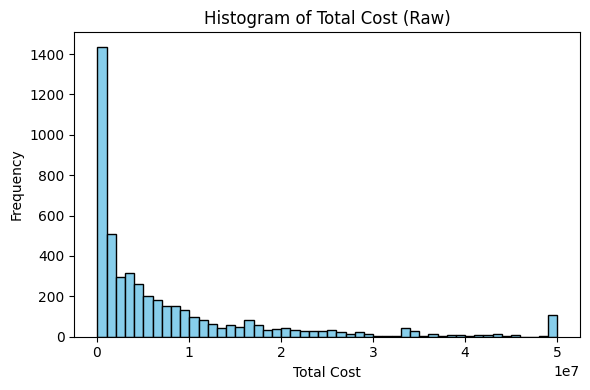

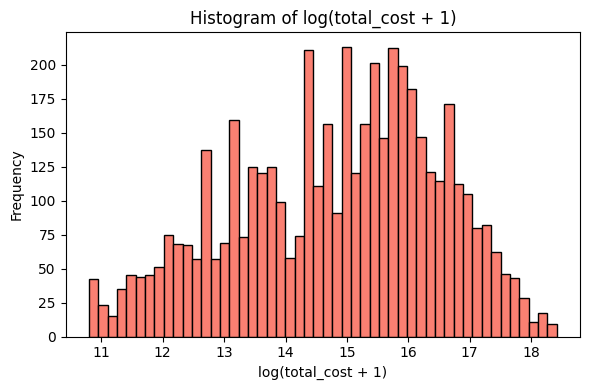

In [23]:
# 4.4. Target distribution before processing
plt.figure(figsize=(6, 4))
plt.hist(train_df["total_cost"].clip(upper=50_000_000), bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Total Cost (Raw)")
plt.xlabel("Total Cost")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Log-transform target for visualization
train_df["log_total_cost_raw"] = np.log1p(train_df["total_cost"])
plt.figure(figsize=(6, 4))
plt.hist(train_df["log_total_cost_raw"], bins=50, color='salmon', edgecolor='black')
plt.title("Histogram of log(total_cost + 1)")
plt.xlabel("log(total_cost + 1)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

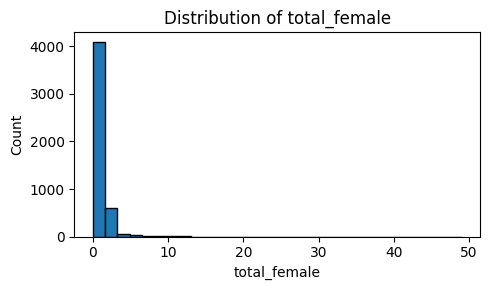

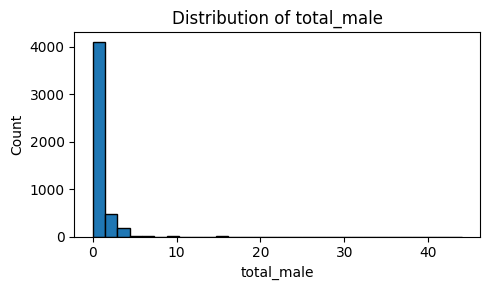

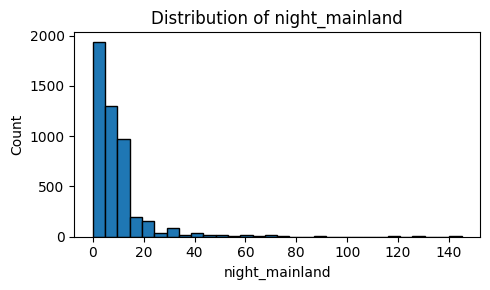

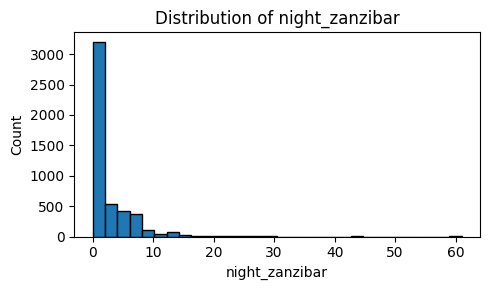

In [24]:
# 4.5. numeric features
numeric_cols = ["total_female", "total_male", "night_mainland", "night_zanzibar"]
for col in numeric_cols:
    plt.figure(figsize=(5, 3))
    plt.hist(train_df[col].fillna(0), bins=30, edgecolor='black')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

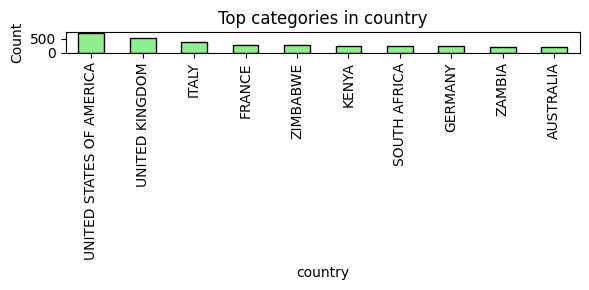

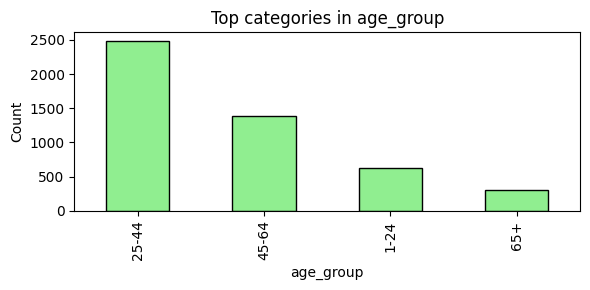

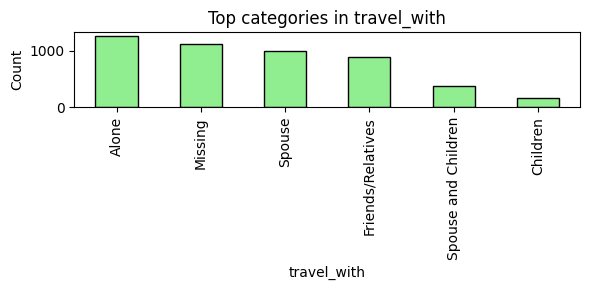

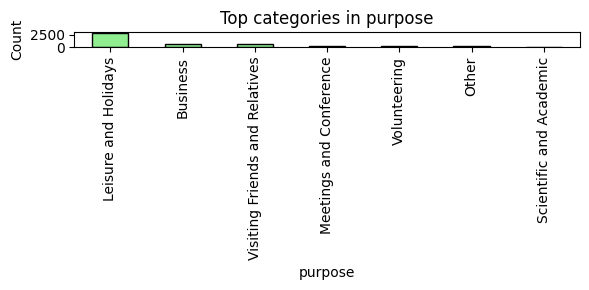

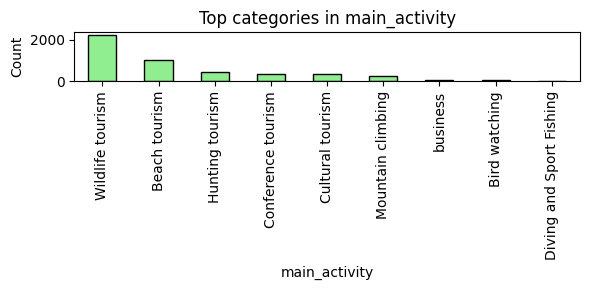

C:\Users\dairo\AppData\Local\Temp\ipykernel_23676\1402427030.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


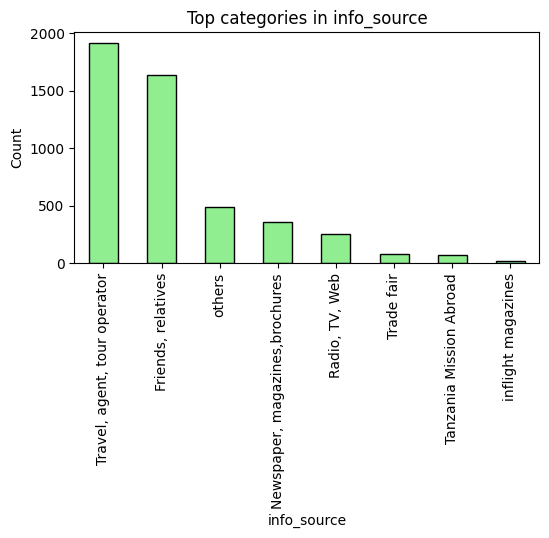

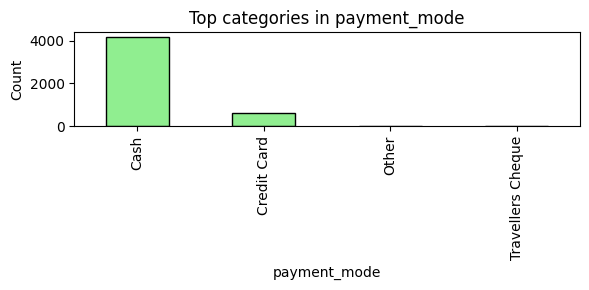

In [25]:
# 4.6. categorical features
categorical_cols = ["country", "age_group", "travel_with", "purpose", "main_activity", "info_source", "payment_mode"]
for col in categorical_cols:
    plt.figure(figsize=(6, 3))
    counts = train_df[col].fillna("Missing").value_counts().sort_values(ascending=False).head(10)
    counts.plot(kind="bar", color='lightgreen', edgecolor='black')
    plt.title(f"Top categories in {col}")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

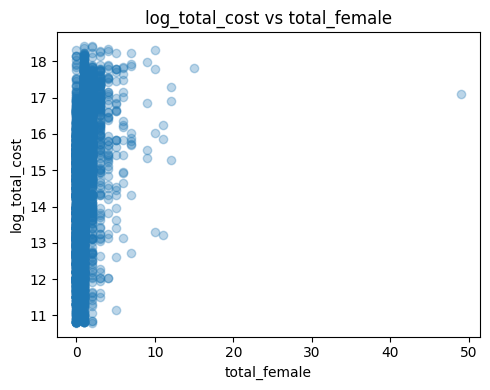

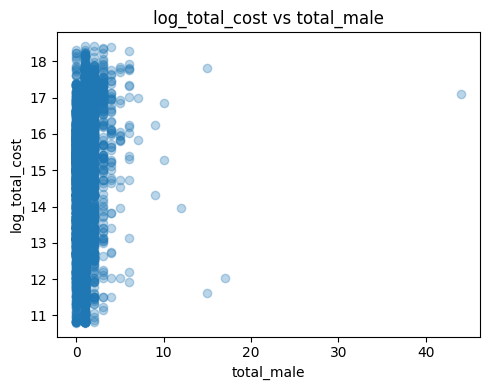

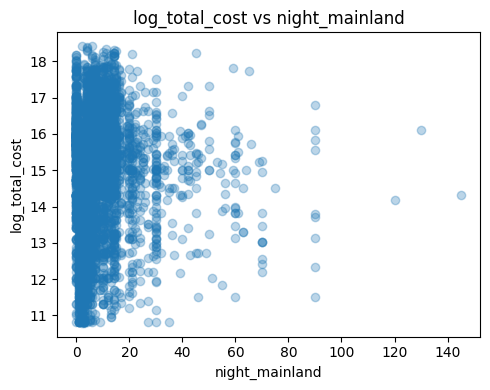

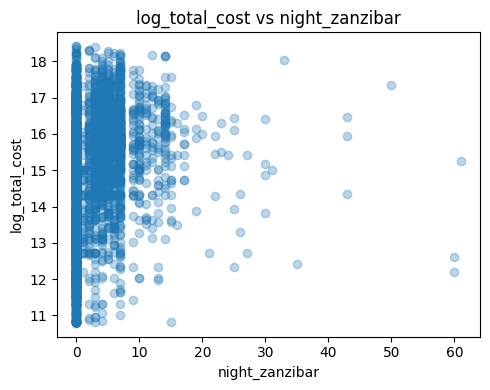

In [26]:
# 4.7. log_total_cost vs numeric features
for col in numeric_cols:
    plt.figure(figsize=(5, 4))
    plt.scatter(train_df[col].fillna(0), train_df["log_total_cost_raw"], alpha=0.3)
    plt.title(f"log_total_cost vs {col}")
    plt.xlabel(col)
    plt.ylabel("log_total_cost")
    plt.tight_layout()
    plt.show()

In [27]:
# ✨ 5. Feature Engineering
# ================================

In [28]:
# 5.1. Clip and log-transform target
train_df["total_cost"] = train_df["total_cost"].clip(upper=25_000_000)
train_df["log_total_cost"] = np.log1p(train_df["total_cost"])

In [29]:
# 5.2. Region and age mapping
region_map = {
    'KENYA': 'Africa', 'TANZANIA': 'Africa', 'UGANDA': 'Africa', 'ETHIOPIA': 'Africa',
    'UNITED STATES OF AMERICA': 'North America', 'CANADA': 'North America',
    'GERMANY': 'Europe', 'FRANCE': 'Europe', 'UNITED KINGDOM': 'Europe', 'ITALY': 'Europe',
    'CHINA': 'Asia', 'JAPAN': 'Asia', 'INDIA': 'Asia',
}
default_region = 'Other'
age_map = {'0-24': 1, '25-34': 2, '35-44': 3, '45-54': 4, '55-64': 5, '65+': 6}

def engineer_features(df, is_train=True):
    # 5.2.1. Map region
    df["region"] = df["country"].map(region_map).fillna(default_region)
    
    # 5.2.2. Fill missing numeric passenger counts
    df["total_female"] = df["total_female"].fillna(0)
    df["total_male"] = df["total_male"].fillna(0)
    df["total_people"] = df["total_female"] + df["total_male"]
    
    # 5.2.3. Aggregate nights
    df["night_mainland"] = df["night_mainland"].fillna(0)
    df["night_zanzibar"] = df["night_zanzibar"].fillna(0)
    df["total_nights"] = df["night_mainland"] + df["night_zanzibar"]
    
    # 5.2.4. Travel companions & solo flags
    df["has_spouse"]   = (df["travel_with"] == "Spouse").astype(int)
    df["has_children"] = (df["travel_with"] == "Children").astype(int)
    df["solo_traveler"] = (df["total_people"] == 1).astype(int)
    
    # 5.2.5. Numeric encoding of age group
    df["age_group_num"] = df["age_group"].map(age_map).fillna(0).astype(int)
    
    # 5.2.6. Interaction features
    df["people_x_nights"]    = df["total_people"] * df["total_nights"]
    df["people_x_mainland"]  = df["total_people"] * df["night_mainland"]
    df["people_x_zanzibar"]  = df["total_people"] * df["night_zanzibar"]
    df["nights_per_person"]  = df["total_nights"] / (df["total_people"] + 1e-6)
    df["mainland_ratio"]     = df["night_mainland"] / (df["total_nights"] + 1e-6)
    df["zanzibar_ratio"]     = df["night_zanzibar"] / (df["total_nights"] + 1e-6)
    
    # 5.2.7. Binary encoding for package columns
    package_cols = [col for col in df.columns if col.startswith("package_")]
    for col in package_cols:
        df[col] = df[col].fillna("No").apply(lambda x: 1 if x == "Yes" else 0)
    
    # 5.2.8. Fill missing for categorical variables
    for col in df.select_dtypes(include="object").columns:
        df[col] = df[col].fillna(df[col].mode()[0])
    
    # 5.2.9. Target encoding on train
    if is_train:
        df["country_te"] = df.groupby("country")["log_total_cost"].transform("mean")
        df["activity_te"] = df.groupby("main_activity")["log_total_cost"].transform("mean")
        df["payment_te"]  = df.groupby("payment_mode")["log_total_cost"].transform("mean")
    
    return df

In [30]:
# 5.3. Apply to training data
train_df = engineer_features(train_df, is_train=True)

In [31]:
# 5.4. Create mapping dictionaries from train for test
country_map   = train_df.groupby("country")["log_total_cost"].mean().to_dict()
activity_map  = train_df.groupby("main_activity")["log_total_cost"].mean().to_dict()
payment_map   = train_df.groupby("payment_mode")["log_total_cost"].mean().to_dict()
global_mean   = train_df["log_total_cost"].mean()

In [32]:
# 5.5. Apply to test data
test_df = engineer_features(test_df, is_train=False)
test_df["country_te"]  = test_df["country"].map(country_map).fillna(global_mean)
test_df["activity_te"] = test_df["main_activity"].map(activity_map).fillna(global_mean)
test_df["payment_te"]  = test_df["payment_mode"].map(payment_map).fillna(global_mean)

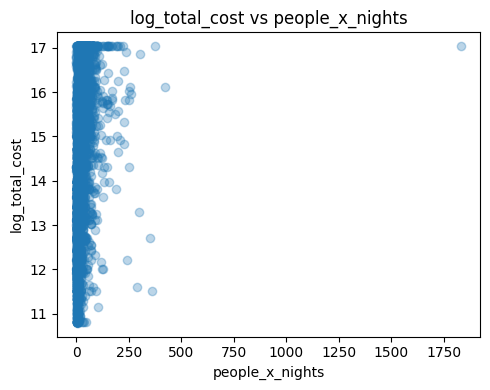

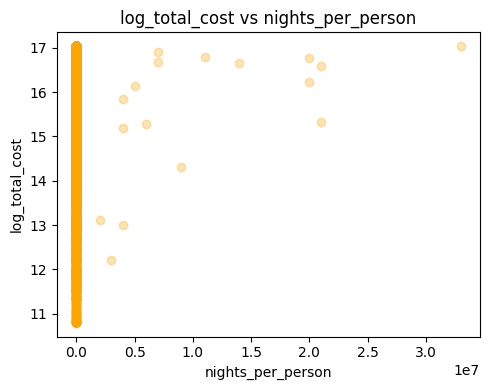

In [33]:
# 5.6. Visualize engineered features vs target
plt.figure(figsize=(5, 4))
plt.scatter(train_df["people_x_nights"], train_df["log_total_cost"], alpha=0.3)
plt.title("log_total_cost vs people_x_nights")
plt.xlabel("people_x_nights")
plt.ylabel("log_total_cost")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 4))
plt.scatter(train_df["nights_per_person"], train_df["log_total_cost"], alpha=0.3, color='orange')
plt.title("log_total_cost vs nights_per_person")
plt.xlabel("nights_per_person")
plt.ylabel("log_total_cost")
plt.tight_layout()
plt.show()

In [34]:
# 🧮 6. PCA for Dimensionality Reduction & Visualization
# ================================

In [35]:
# 6.1. Select numeric columns for PCA (after feature engineering)
pca_numeric_cols = [
    "total_female", "total_male", "night_mainland", "night_zanzibar",
    "total_people", "total_nights", "people_x_nights", "people_x_mainland", "people_x_zanzibar",
    "nights_per_person", "mainland_ratio", "zanzibar_ratio",
    "age_group_num", "country_te", "activity_te", "payment_te"
]

X_pca = train_df[pca_numeric_cols].fillna(0).values

In [36]:
# 6.2. Standardize features before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

In [37]:
# 6.3. Fit PCA
pca = PCA(n_components=0.95, random_state=42) 
X_pca_transformed = pca.fit_transform(X_scaled)
print(f"\n🔹 Number of components to explain 95% variance: {pca.n_components_}")


🔹 Number of components to explain 95% variance: 10


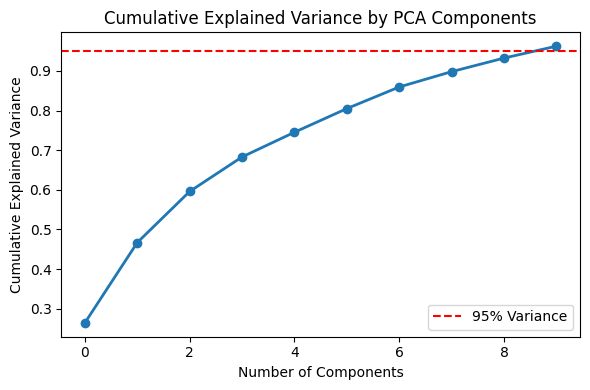

In [38]:
# 6.4. Explained variance plot
plt.figure(figsize=(6, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linewidth=2)
plt.axhline(0.95, linestyle='--', color='red', label='95% Variance')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

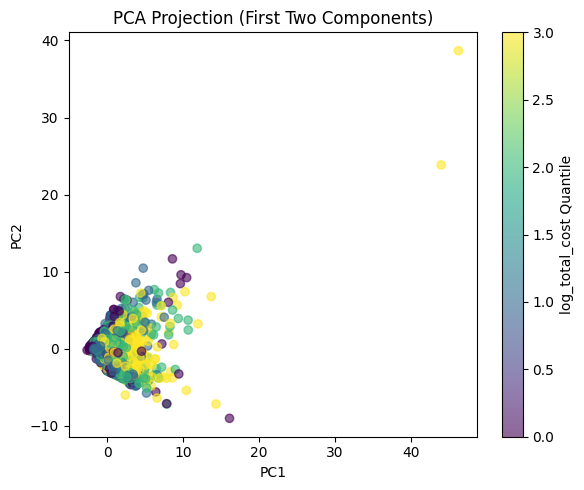

In [39]:
# 6.5. Scatter plot of first two principal components colored by log_total_cost quantiles
quantiles = pd.qcut(train_df["log_total_cost"], q=4, labels=False)
plt.figure(figsize=(6, 5))
scatter = plt.scatter(
    X_pca_transformed[:, 0], X_pca_transformed[:, 1],
    c=quantiles, cmap='viridis', alpha=0.6
)
plt.colorbar(scatter, label="log_total_cost Quantile")
plt.title("PCA Projection (First Two Components)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

In [40]:
# 📊 7. Prepare Data for Modeling
# ================================


In [41]:
# 7.1. Define feature list (categorical + engineered numeric + target-encodings)
features = [
    'region', 'age_group', 'travel_with', 'purpose', 'main_activity', 'info_source',
    'tour_arrangement', 'payment_mode',
    'package_transport_int', 'package_accomodation', 'package_food',
    'package_transport_tz', 'package_sightseeing', 'package_guided_tour',
    'package_insurance',
    'total_female', 'total_male', 'night_mainland', 'night_zanzibar',
    'total_people', 'total_nights', 'has_spouse', 'has_children',
    'people_x_nights', 'solo_traveler', 'age_group_num',
    'nights_per_person', 'people_x_mainland', 'people_x_zanzibar',
    'mainland_ratio', 'zanzibar_ratio',
    'country_te', 'activity_te', 'payment_te'
]

X = train_df[features]
y = train_df["log_total_cost"]
X_test = test_df[features]

In [42]:
# 7.2. Identify categorical columns for CatBoost
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
print("\n🔹 Categorical columns:", cat_cols)


🔹 Categorical columns: ['region', 'age_group', 'travel_with', 'purpose', 'main_activity', 'info_source', 'tour_arrangement', 'payment_mode']


In [43]:
# 🤖 8. Stratified K-Fold Training & Prediction
# ================================

In [44]:
# 8.1. Create stratification bins based on total_cost
train_df["cost_bin"] = pd.qcut(train_df["total_cost"], 5, labels=False)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
val_maes = []
fold_preds = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, train_df["cost_bin"])):
    print(f"\n🔁 Fold {fold + 1}")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    train_pool = Pool(X_train, y_train, cat_features=cat_cols)
    val_pool   = Pool(X_val, y_val, cat_features=cat_cols)
    test_pool  = Pool(X_test, cat_features=cat_cols)

    tmp_dir = tempfile.mkdtemp()
    model = CatBoostRegressor(
        iterations=1750,
        learning_rate=0.022,
        depth=9,
        l2_leaf_reg=6,
        subsample=0.85,
        loss_function='Quantile:alpha=0.6',
        early_stopping_rounds=100,
        random_seed=42 + fold,
        verbose=100,
        train_dir=tmp_dir
    )
    model.fit(train_pool, eval_set=val_pool)
    shutil.rmtree(tmp_dir, ignore_errors=True)

    # Predictions and MAE
    val_preds = np.expm1(model.predict(val_pool))
    test_preds = np.expm1(model.predict(test_pool))
    
    y_val_exp = np.expm1(y_val)
    val_mae = mean_absolute_error(y_val_exp, val_preds)
    print(f"✅ Fold {fold + 1} MAE: {val_mae:.2f}")
    
    val_maes.append(val_mae)
    fold_preds.append(test_preds)


🔁 Fold 1
0:	learn: 0.6185962	test: 0.6194496	best: 0.6194496 (0)	total: 95.8ms	remaining: 2m 47s
100:	learn: 0.3323555	test: 0.3682102	best: 0.3682102 (100)	total: 9.5s	remaining: 2m 35s
200:	learn: 0.2915504	test: 0.3576213	best: 0.3572664 (186)	total: 18.9s	remaining: 2m 25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3572664345
bestIteration = 186

Shrink model to first 187 iterations.
✅ Fold 1 MAE: 3322597.64

🔁 Fold 2
0:	learn: 0.6196096	test: 0.6156442	best: 0.6156442 (0)	total: 103ms	remaining: 2m 59s
100:	learn: 0.3294496	test: 0.3745010	best: 0.3745010 (100)	total: 9.37s	remaining: 2m 33s
200:	learn: 0.2893442	test: 0.3619932	best: 0.3619932 (200)	total: 19.1s	remaining: 2m 27s
300:	learn: 0.2705406	test: 0.3606902	best: 0.3606902 (300)	total: 28.6s	remaining: 2m 17s
400:	learn: 0.2566295	test: 0.3611334	best: 0.3606902 (300)	total: 38.8s	remaining: 2m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3606902381
bestIteration = 

In [45]:
# 8.2. Average validation MAE
avg_mae = np.mean(val_maes)
print(f"\n🔹 Average Validation MAE (5-Fold): {avg_mae:.2f}")


🔹 Average Validation MAE (5-Fold): 3350829.82


In [46]:
# 8.3. Final ensemble predictions
final_preds = np.mean(fold_preds, axis=0)
final_preds = np.clip(final_preds, 50_000, 25_000_000)

In [47]:
# 💾 9. Save Submission
# ================================
submission = pd.DataFrame({
    "ID": test_ids,
    "total_cost": final_preds
})
submission_path = os.path.join(OUTPUT_DIR, "submission.csv")
submission.to_csv(submission_path, index=False)
print(f"✅ submission.csv saved to {submission_path}")


✅ submission.csv saved to d:\Prog\Python\TouriSpend\submission\submission.csv
